# Neural Style Transfer

El siguiente código fue adaptado de la documentación de [keras](https://keras.io/examples/neural_style_transfer/) y del siguiente notebook de [kaggle](https://www.kaggle.com/basu369victor/style-transfer-deep-learning-algorithm). El paper original es [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576).

En la carpeta `imagenes_nst` pueden encontrar imágenes para usar como imagen de estilo. Recomendamos, igualemente, seleccionar de la web alguna que les guste. Hacer lo mismo para la imagen de contenido.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#No olvidar la instalación de pillow
#conda install -c anaconda pillow
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array

from scipy.optimize import fmin_l_bfgs_b
import time

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K


Elegimos las imágenes que vamos a usar: la imagen de base (contenido) y la imagen de estilo.

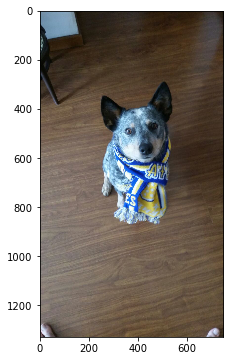

In [8]:
nombre_base = 'Flechas.jpg'
base_image_path = 'DS_44/imagenes_nst/' + nombre_base
plt.figure(figsize = (8,6))
plt.imshow(plt.imread(base_image_path))
plt.show()

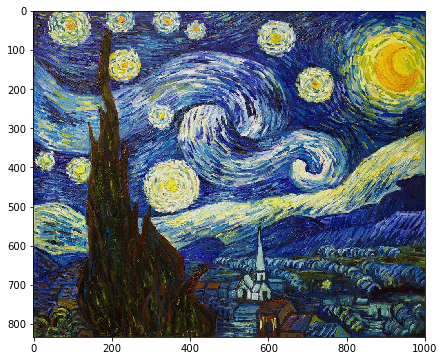

In [9]:
nombre_estilo = 'van_gogh_noche.jpg'
style_reference_image_path = 'DS_44/imagenes_nst/' + nombre_estilo
plt.figure(figsize = (8,6))
plt.imshow(plt.imread(style_reference_image_path))
plt.show()

Y cómo y dónde vamos a guardar las imágenes que se generen

In [10]:
result_prefix = "DS_44/imagenes_nst/" + nombre_base[:-4] + '_' + nombre_estilo[:-4]
result_prefix

'DS_44/imagenes_nst/Flechas_van_gogh_noche'

Luego, algunos parámetros de la corrida y de la imagen generada

In [11]:
iterations = 50

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

### VGGNet

VGGNet es una red neuronal (en realidad hay varias disponibles) pre-entrenada que puede descargarse de internet. Recomendamos buscar cómo fue entrenado y para qué problema. En esta aplicación no es necesario seguir entrenando la red, sino solamente usarla para procesar las imágenes.

Definimos algunas funciones necesarias para trabajar con las imágenes y adaptamos las imágenes al *formato* que requiere la red (tensor):

In [12]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

Instructions for updating:
Colocations handled automatically by placer.


Cargamos el modelo. **Notar el** `include_top = False`. ¿A qué se deberá? Si es la primera vez puede tardar un poco mientras lo descarga

In [14]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False) 
print('Model loaded.')

Model loaded.


### Funciones de costo

Definimos algunas funciones auxiliares y los costos

In [17]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# combine these loss functions into a single scalar
#loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = (content_weight * content_loss(base_image_features,
                                      combination_features))

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss+=((style_weight / len(feature_layers)) * sl)
loss += (total_variation_weight * total_variation_loss(combination_image))

### Descenso por gradiente

Funciones auxiliares para hacer descenso por gradiente

In [18]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Y generamos la imagen

In [19]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 6236128000.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_noche_at_iteration_0.png')
Iteration 0 completed in 98s
('Start of iteration', 1)
('Current loss value:', 3441181700.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_noche_at_iteration_1.png')
Iteration 1 completed in 98s
('Start of iteration', 2)
('Current loss value:', 2722444800.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_noche_at_iteration_2.png')
Iteration 2 completed in 99s
('Start of iteration', 3)
('Current loss value:', 2390084600.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_noche_at_iteration_3.png')
Iteration 3 completed in 99s
('Start of iteration', 4)
('Current loss value:', 2207574500.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_noche_at_iteration_4.png')
Iteration 4 completed in 99s
('Start of iteration', 5)
('Current loss value:', 2102051600.0)
('Image saved as', 'DS_44/imagenes_nst/Flechas_van_gogh_

KeyboardInterrupt: 